<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/Exemplo_Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-encoder para limpar ruído

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import keras

from keras.models import Model
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, UpSampling2D

print(keras.__version__)

2.14.0


In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
# normalize train data
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
print(x_train.shape)

(60000, 28, 28, 1)


In [5]:
# normalize test data (which serves as our labels)
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_test.shape)

(10000, 28, 28, 1)


## Aqui é onde adicionamos ***ruido*** nas nossas imagens.


In [6]:
# create noisy data for train and test
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [7]:
# renormalize through clipping
# o clipping vai cortar o "excedente" do ruido nos extremos para voltar a ficar na escala escolhida
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [8]:
# create the encode network
input_img = Input(shape=(28,28,1))
x = Convolution2D(32,(3,3),activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2),padding='same')(x)
x = Convolution2D(32,(3,3),activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)
# 7,7,32

In [9]:
# create the decode network
x = Convolution2D(32,(3,3),activation='relu',padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Convolution2D(32,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Convolution2D(1,(3,3),activation='sigmoid',padding='same')(x)
#back to 28,28,1

In [10]:
# create the autoencoder by tying the encode and decode networks together
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

In [11]:
# train
autoencoder.fit(x_train_noisy, x_train,
  epochs=10,
  batch_size=256,
  shuffle=True,
  validation_data=(x_test_noisy, x_test))

Epoch 1/10
235/235 [==============================] - 7s 13ms/step - loss: 0.2021 - val_loss: 0.1256
Epoch 2/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1210 - val_loss: 0.1155
Epoch 3/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1142 - val_loss: 0.1105
Epoch 4/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1103 - val_loss: 0.1082
Epoch 5/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1079 - val_loss: 0.1077
Epoch 6/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1061 - val_loss: 0.1043
Epoch 7/10
235/235 [==============================] - 5s 19ms/step - loss: 0.1046 - val_loss: 0.1030
Epoch 8/10
235/235 [==============================] - 4s 15ms/step - loss: 0.1035 - val_loss: 0.1026
Epoch 9/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1025 - val_loss: 0.1012
Epoch 10/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1016 - val_lo

In [12]:
# create the encoder model
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
Total params: 9568 (37.38 KB)
Trainable params: 9568 (37.38

In [13]:
# create the decoder model
encoded_input = Input(shape=(7,7,32))

def dodecoder(x,list_layers,nlayers):
  layer_seq = list_layers[-nlayers:]
  decoded_input = x
  for decoder_ in layer_seq:
      decoded_input = decoder_(decoded_input)
  return decoded_input

# this is pretty ugly.  there is a better way ABOVE!
# decoder1 = autoencoder.layers[-5]
# decoder2 = autoencoder.layers[-4]
# decoder3 = autoencoder.layers[-3]
# decoder4 = autoencoder.layers[-2]
# decoder5 = autoencoder.layers[-1]
# decoder = Model(encoded_input, decoder5(decoder4(decoder3(decoder2(decoder1(encoded_input))))))
# decoder.summary()

In [14]:
a=dodecoder(encoded_input,autoencoder.layers,5)
new_decoder=Model(encoded_input,a)
new_decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 32)]        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 1)         289 

In [15]:
# run noisy test data through the encoder
encoded_imgs = encoder.predict(x_test_noisy)

# run encoded noisy test image back through the decoder
decoded_imgs = new_decoder.predict(encoded_imgs)

# make sense of the shapes
print(encoded_imgs.shape)
print(decoded_imgs.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 7, 7, 32)
(10000, 28, 28, 1)


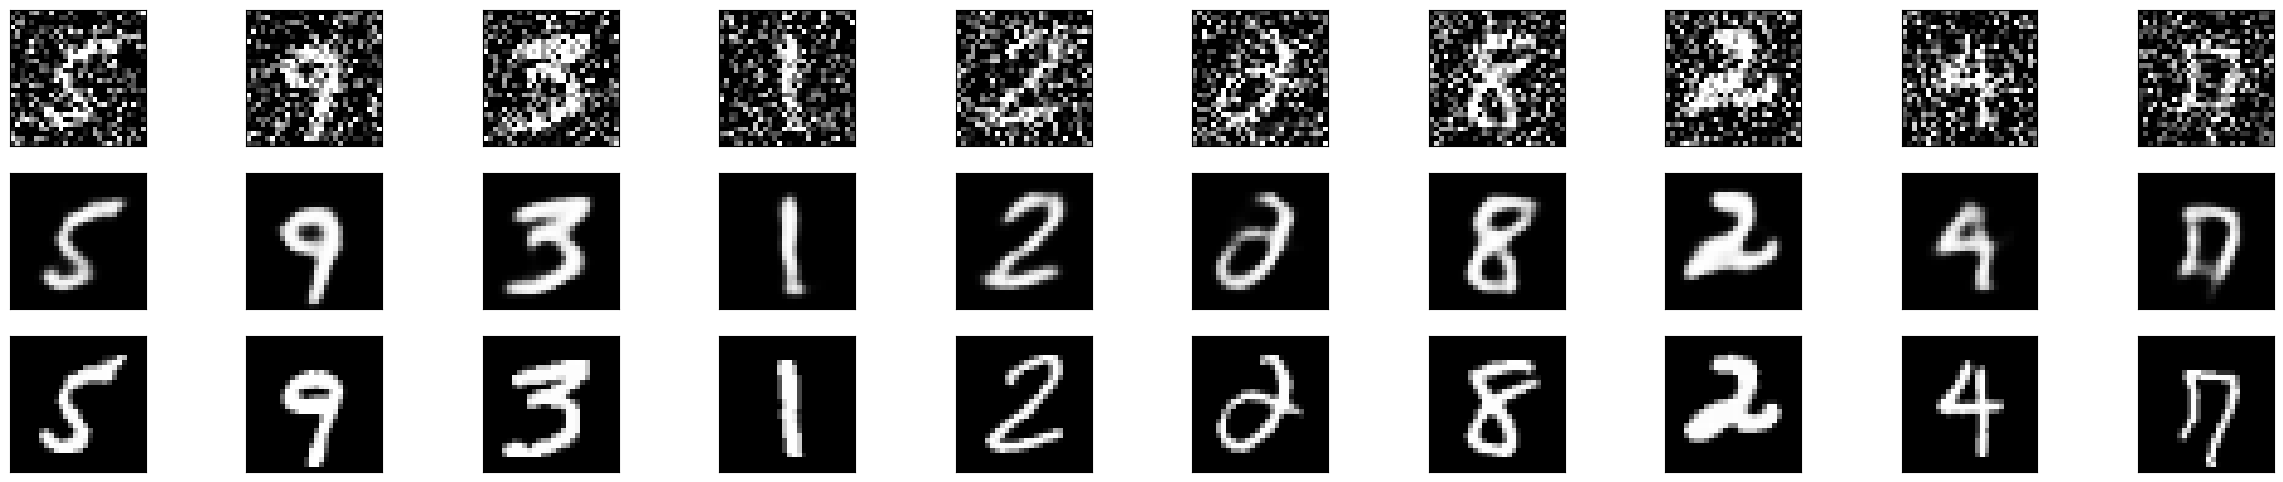

In [16]:
# display n random images
n = 9
indxs = np.random.randint(0,9999,n)


## achei um digito bem ambiguo que o algoritmo de denoising reconstruiu diferente
## se o ruido subir para 0.7, vou salvar para ver como se comporta com outros niveis de ruido
## com noise_factor <= 0.6 consegue voltar ao original

indxs = np.append(indxs,1494)
n=n+1


plt.figure(figsize=(30,6))
for j,i in enumerate(indxs):

  # noisy images
  ax = plt.subplot(3,n,j+1)
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # denoised images
  ax = plt.subplot(3,n,j+1+n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # original images
  ax = plt.subplot(3,n,j+1+n*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Proposta de exercício:
   * Tente mudar o fator de ruido para valores maiores (0.8-0.9) e retreinar o algoritmo, se ve alguma diferença? (Observe o que acontece se achar numeros muito ambiguos, ex. a imagem de indice = 1494 que parece um 7 esquisito)
   * O que acontece tambem se aumentar o ruido so no dataset de teste e aplicar o modelo que foi treinado com ruido moderado (0.5-0.6) nas imagens com ruido alto (0.8-0.9)??

In [17]:
new_noise=0.9
x_test_supernoisy  = x_test + new_noise* np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [18]:
# run noisy test data through the encoder
encoded_imgs_sn = encoder.predict(x_test_supernoisy)

# run encoded noisy test image back through the decoder
decoded_imgs_sn = new_decoder.predict(encoded_imgs_sn)

313/313 [==============================] - 1s 2ms/step


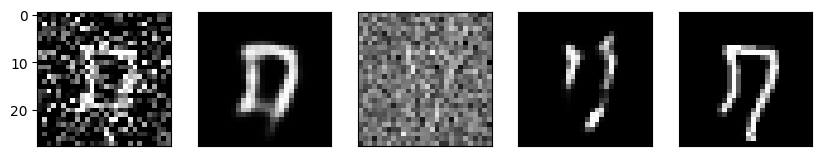

In [33]:
plt.figure(figsize=(10,6))
i=1494
#i=np.random.randint(0,9999)
# noisy images for training
ax = plt.subplot(1,5,1)
plt.imshow(x_test_noisy[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)

# denoised images
ax = plt.subplot(1,5,2)
plt.imshow(decoded_imgs[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


#super noisy images for test
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1,5,3)
plt.imshow(x_test_supernoisy[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# denoised images
ax = plt.subplot(1,5,4)
plt.imshow(decoded_imgs_sn[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# original images
ax = plt.subplot(1,5,5)
plt.imshow(x_test[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

8212